In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [8]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)



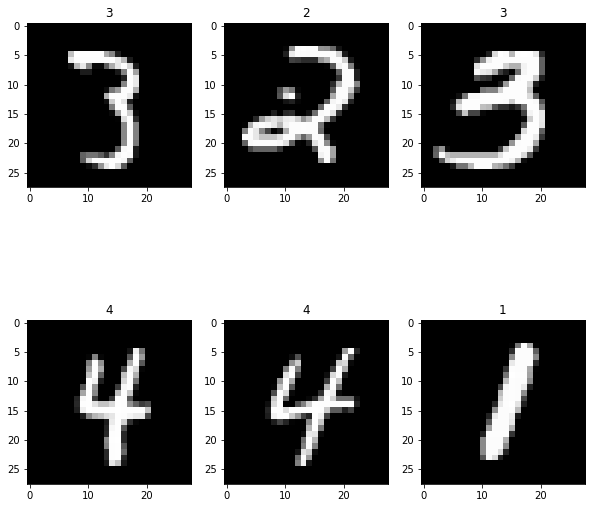

In [9]:
# look at some figures from the training_data:

figure = plt.figure(figsize=(10, 10))
rows, cols = 2, 3
for i in range(1,cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis=("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [11]:
"""
    Glues Mnist-Image data fo 28 X 28 images to a multi-figure number.
    The width of the images is randomly clipped before glueing to make it more alike a real hand written multi-cifer number.
    
    Input:
        nof_cifers : number of figures in the output number
        data : torch.dataset containing (image, label) - pairs
    
    Output:
        returns :
            multi_img : a torch tensor of the image of the glued numbers - size: [1, 28, nof_cifers X 28]
            multi_img_label : a torch.int32 number glued from the individual labels
            merge_points : a list of integers giving the x-coordinates of the points where the MNIST numbers where glued
"""
def merge_MNIST(data, nof_cifers=2):

    # check for some bogus input:
    #if nof_cifers == 1:
    #    return data[0], data[1], [data[0].shape[1]]

    #if len(data) == 1:
    #    return data[0][0], data[0[1], [data[0][0].shape[1]]
    
    #if nof_cifers > len(data):
    #    return data[0][0], data[0[1], [data[0][0].shape[1]]
    
    crop_height = 28
    crop_images = []
    labels = []
    merge_points = []
    merge_point = 0
    nof_images = len(data)
    # initialization of random generator:
    for i in range(nof_cifers):
        # chose random image:
        sample_id = torch.randint(nof_images, size=(1,), dtype=torch.int32).item()
        img, label = data[sample_id]
        labels.append(label)
        # chose random clipping parameters:
        crop_left = torch.randint(8, size=(1,), dtype=torch.int32)
        crop_width = torch.randint(20, 28, size=(1,), dtype= torch.int32)
        crpimg= TT.functional.crop(img, top=0, left=crop_left, height=crop_height, width=crop_width)
        # store clipped images for later merging:
        crop_images.append(crpimg)
        # store x-coordinate of merge-point:
        merge_point = merge_point + crop_width.item()
        merge_points.append(merge_point)
        #plt.imshow(crpimg.squeeze(), cmap="gray") # for debugging
    
    # fill image with black space to full dimensions:
    black_fill = torch.zeros([1,28, nof_cifers * 28 - merge_points[-1]])
    crop_images.append(black_fill)
    multi_img = torch.cat(crop_images, dim = 2)
    multi_img_label = "".join([str(j) for j in labels])
    merge_points = torch.Tensor(merge_points)

    return multi_img, multi_img_label, merge_points





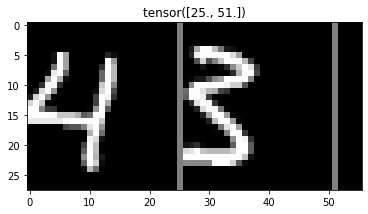

In [14]:
# check the points, where the images are merged ("merge_points"), by drawing a grey vertical line:

from PIL import ImageDraw # used to draw lines on an image

multi_img, multi_img_label, merge_points = merge_MNIST(training_data, nof_cifers=2)
im = TT.ToPILImage()(multi_img)
draw = ImageDraw.Draw(im)
for mp in merge_points:
    draw.line([(mp, 0), (mp, 28)], width=1, fill=128)
plt.title(merge_points)
plt.imshow(im, cmap="gray")

In [4]:
import torchvision.transforms as TT
from pathlib import Path, PureWindowsPath


"""
Generates and writes a given number of images-records of handwritten numbers, consisting of a given number of digits (ciphers) 
into a directory. 
A record is a dictionary with the following entries:
record["multi_img"] : image tensor glued from several Mnist images, 
record["multi_img_label"] : multi label the number represented in the image, 
record["merge_points"] : merge points' x-coordinates - the places where the images have been glued together
The names of the images generated are for example:
filename: "1234" + "_26_48_75_97" + ".pt" for an image of the number "1234" and merge-points at 26, 48, 75, 97 pixels, counted from the left border.

Input:
    target_directory : directory to write the images into
    number_of_ciphers : the number of digits an immage has to contain
    number_of_records : the number of images generated an written in to the directory

Output:
    a number of image-records written into the directory.
    An image-record is a dictionary with the structure:
    record["multi_img"] : image tensor, 
    record["multi_img_label"] : multi label, 
    record["merge_points"] : merge points x-coordinates

    returns : 
        None
"""
def write_multi_records(target_directory, number_of_cifers, mumber_of_records):
    target_dir = Path(target_directory)
    target_dir.mkdir(exist_ok=True)
    nof_cifers = number_of_cifers

    # Write mumber_of_records samples into folder:
    for i in range(mumber_of_records):
        multi_img, multi_img_label, merge_points = merge_MNIST(training_data, nof_cifers=number_of_cifers)
        multi_record = { 
            "multi_img": multi_img, 
            "multi_img_label" : multi_img_label, 
            "merge_points" : merge_points 
        }
        # filename example: "1234" + "_26_48_75_97" + ".pt" 
        multi_name = multi_img_label + "_" + "_".join([str(int(mp.item())) for mp in merge_points]) + ".pt"
        torch.save(multi_record, target_dir / multi_name)

In [71]:
# test write_multi_records:

write_multi_records("test2", 2, 10)

{'multi_img': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'multi_img_label': '77219', 'merge_points': tensor([ 22.,  44.,  67.,  89., 110.])}
mr["multi_img"].shape : torch.Size([1, 28, 140])
merge_points: tensor([ 22.,  44.,  67.,  89., 110.])


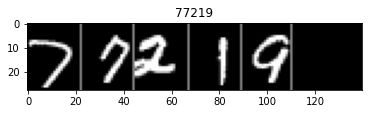

In [21]:
# load example:
mr = torch.load("Mnist5_val/77219_22_44_67_89_110.pt")
print(mr)

import torchvision.transforms as TT
import matplotlib.pyplot as plt
t_img = mr["multi_img"]
print(f"mr[\"multi_img\"].shape : {t_img.shape}")
merge_points = mr["merge_points"]
print(f"merge_points: {merge_points}")
img = TT.ToPILImage()(mr["multi_img"])
plt.title(mr["multi_img_label"])
draw = ImageDraw.Draw(img)
for mp in merge_points:
    draw.line([(mp, 0), (mp, 28)], width=1, fill=128)
plt.imshow(img, cmap="gray")

In [15]:
# create directory for validation data : "MnistX_val", with 200 images of X digit numbers:

number_of_cifers = 2

val_target_directory = "Mnist" + str(number_of_cifers) + "_val"
mumber_of_val_records = 200
write_multi_records(val_target_directory, number_of_cifers, mumber_of_val_records)

In [74]:
# creat directory for training data : "MnistX_val", with 1000 images of X digit numbers:

number_of_cifers = 2

train_target_directory = "Mnist" + str(number_of_cifers) +"_train"
number_of_train_records = 1000
write_multi_records(train_target_directory, number_of_cifers, number_of_train_records)

Mnist5_train
